<a href="https://colab.research.google.com/github/blackBagel/flu-shots/blob/main/Flu_shot_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
from google.colab import drive
from tqdm import tqdm
from joblib import Parallel, delayed
import re
# from currency_converter import CurrencyConverter

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# from category_encoders import CountEncoder
from sklearn.model_selection import train_test_split
# from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# import eli5
import pickle
from time import perf_counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DRIVE_PATH = '/gdrive/My Drive/Data_Projects/Flu_Shots'
drive.mount('/gdrive')
os.chdir(DRIVE_PATH)
!ls

Mounted at /gdrive
submission_format.csv  training_set_features.csv
test_set_features.csv  training_set_labels.csv


In [3]:
full_train_df = pd.read_csv("training_set_features.csv")
full_train_labels = pd.read_csv("training_set_labels.csv")

In [4]:
full_train_df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [5]:
full_train_labels

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [64]:
full_train_df = full_train_df.set_index("respondent_id")
full_train_labels = full_train_labels.set_index("respondent_id")

# Checking if there are inconcistency issues in the data
(full_train_df.index != full_train_labels.index).sum()

0

In [66]:
full_train_labels

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1


#### Train validation split

In [7]:
# Checking how many observations in test set
! wc -l "test_set_features.csv"

26709 test_set_features.csv


Unfortunately, the test set is the same size as the train set.  
So since i can't create a validation set as big, i'll just take a small fraction of the train set for validation

In [67]:
TRAIN_VAL_RAND_STATE = 1
TRAIN_VAL_SPLIT = 0.2

# We use the same train-test split to test all of the models
df_train, df_val, labels_train, labels_val = train_test_split(full_train_df,
                                                              full_train_labels,
                                                              random_state=TRAIN_VAL_RAND_STATE,
                                                              test_size=TRAIN_VAL_SPLIT,
                                                              shuffle=True)

print(f"train size: {len(df_train)}")
print(f"val size: {len(df_val)}")
print(f"train labels size: {len(labels_train)}")
print(f"val labels size: {len(labels_val)}")

train size: 21365
val size: 5342
train labels size: 21365
val labels size: 5342


# H1N1 shots
I want to handle each problem orthonogically. After I'll feel I know enough about H1N1 predictions, I'll start working on improving flu shot scores as well.

### Finding best features

In [51]:
def describe_columns(df):
  TOO_MANY_NULLS_PERCENT = 0.01
  columns_with_lots_of_nulls = []

  print(f"The df has {df.shape[1]} columns")
  print("Column name                  | dtype   | Amount of nulls")
  print("--------------------------------------------------------")
  for column in df.columns:
    num_of_nulls = df[column].isnull().sum()
    col_dtype = str(df.dtypes[column])
    print(f"{column:<28} | {col_dtype:<7} | {num_of_nulls}")

    if num_of_nulls > len(df_train) * TOO_MANY_NULLS_PERCENT:
      columns_with_lots_of_nulls.append(column)

  print()
  print(f"Columns that have more than {TOO_MANY_NULLS_PERCENT * 100}% null values:")
  print(columns_with_lots_of_nulls)

describe_columns(df_train)

The df has 36 columns
Column name                  | dtype   | Amount of nulls
--------------------------------------------------------
respondent_id                | int64   | 0
h1n1_concern                 | float64 | 75
h1n1_knowledge               | float64 | 87
behavioral_antiviral_meds    | float64 | 56
behavioral_avoidance         | float64 | 178
behavioral_face_mask         | float64 | 14
behavioral_wash_hands        | float64 | 32
behavioral_large_gatherings  | float64 | 68
behavioral_outside_home      | float64 | 66
behavioral_touch_face        | float64 | 97
doctor_recc_h1n1             | float64 | 1729
doctor_recc_seasonal         | float64 | 1729
chronic_med_condition        | float64 | 792
child_under_6_months         | float64 | 665
health_worker                | float64 | 650
health_insurance             | float64 | 9829
opinion_h1n1_vacc_effective  | float64 | 327
opinion_h1n1_risk            | float64 | 322
opinion_h1n1_sick_from_vacc  | float64 | 326
opinion_seas_vac

### Handling string columns

### Handling nulls

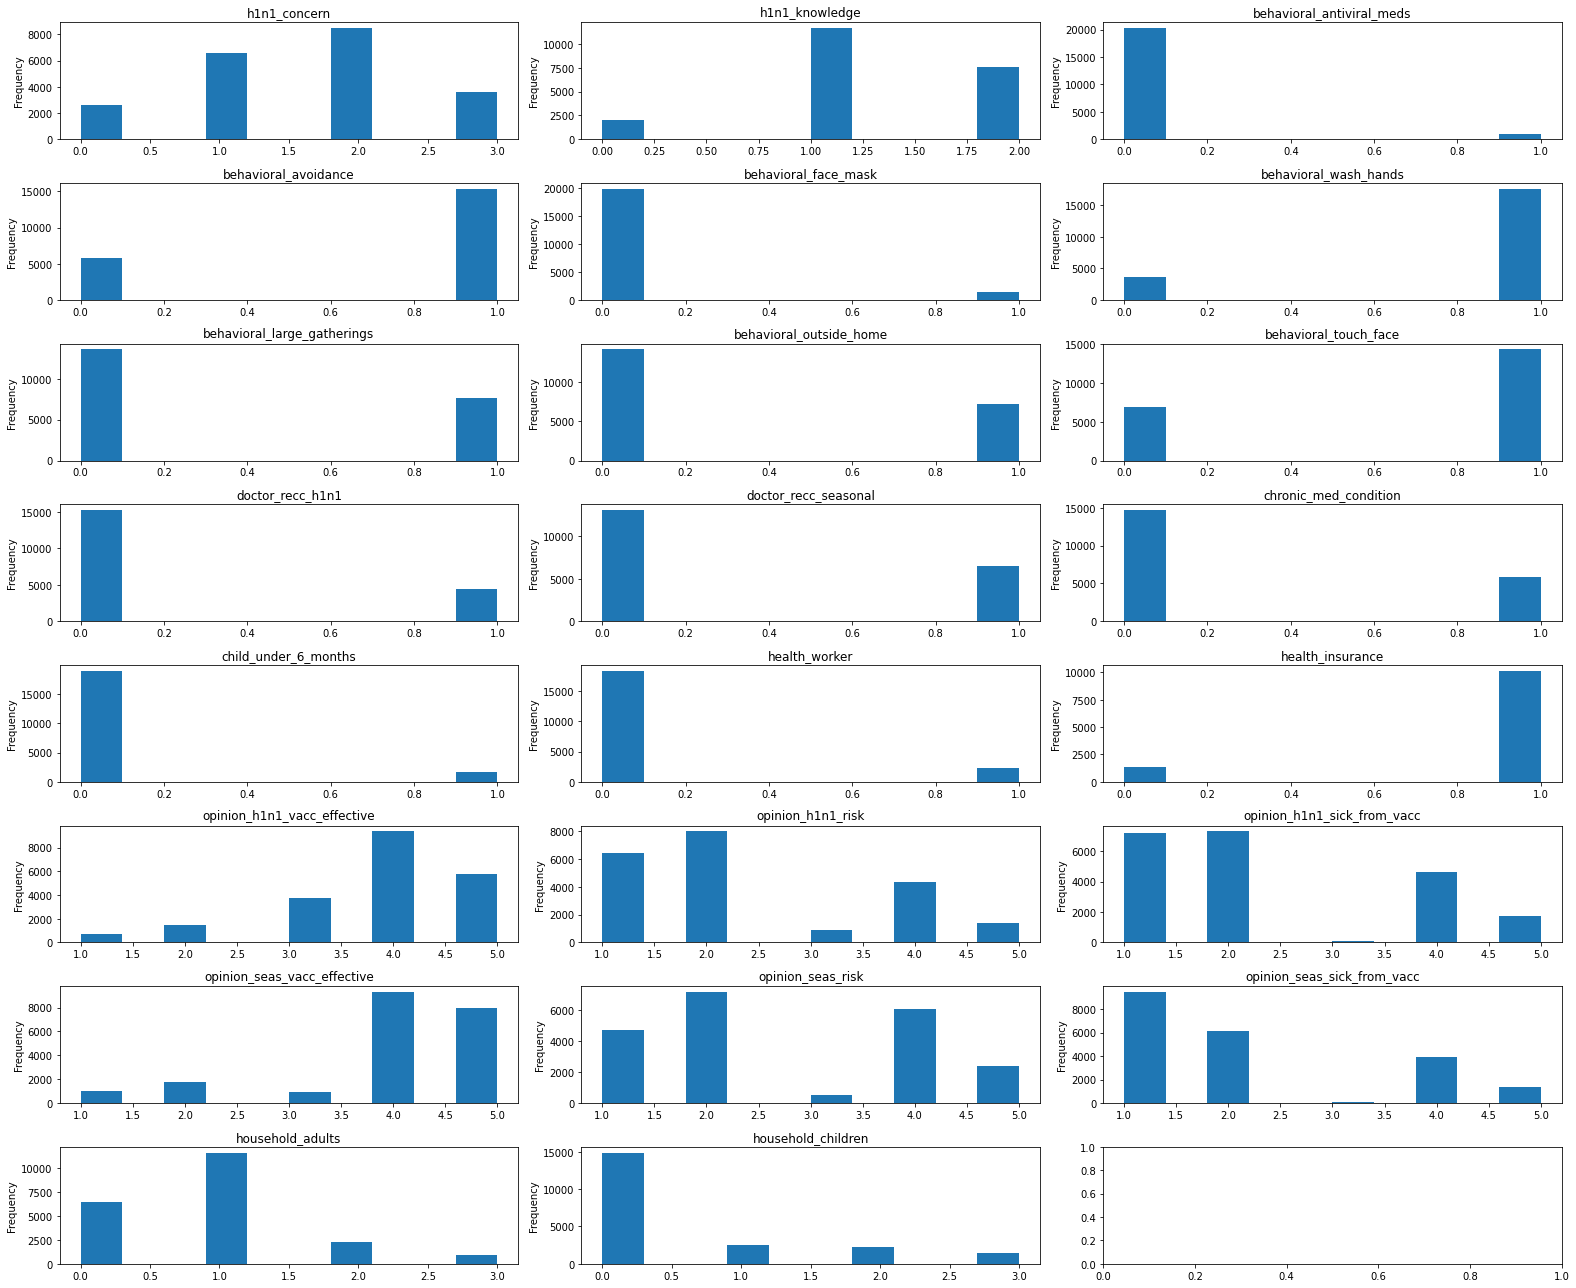

In [44]:
# We'll plot every whole month in the last year 
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(22,18))
axes_list = [item for sublist in axes for item in sublist] 

# plot every month's daily count of transactions
for column in df_train.select_dtypes(include=['float64']).columns:
  ax = axes_list.pop(0)
  df_train[column].plot(kind='hist', ax=ax)
  ax.set_title(column)

fig.tight_layout()

In [ ]:
# columns_that_can_have_better_impute = ['doctor_recc_h1n1', # X
#                                        'doctor_recc_seasonal', # X
#                                        'health_insurance', # V
#                                        'education', # 
#                                        'income_poverty',
#                                        'marital_status',
#                                        'rent_or_own',
#                                        'employment_status', 
#                                        'employment_industry',
#                                        'employment_occupation']


In [68]:
FLOAT_FEATURES_TO_CLASSIFY_BY = list(df_train.select_dtypes(include=['float64']).columns)
FLOAT_FEATURES_TO_CLASSIFY_BY.remove('doctor_recc_h1n1')
FLOAT_FEATURES_TO_CLASSIFY_BY.remove('doctor_recc_seasonal')

FEATURES_TO_CLASSIFY_BY = FLOAT_FEATURES_TO_CLASSIFY_BY
df_train_for_clf = df_train[FEATURES_TO_CLASSIFY_BY]

In [74]:
features_for_mf_impute = FLOAT_FEATURES_TO_CLASSIFY_BY
most_freq_imputer = SimpleImputer(strategy='most_frequent')

data_preparation_pipeline = Pipeline([('Impute', most_freq_imputer)])

In [97]:
df_train_processed = data_preparation_pipeline.fit_transform(df_train_for_clf)

df_train_processed = pd.DataFrame(df_train_processed,
                                  columns = df_train_for_clf.columns,
                                  index=df_train_for_clf.index)

df_train_processed

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
22542,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,2.0,4.0,3.0,1.0
15778,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,4.0,2.0,0.0,1.0
15152,3.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,5.0,2.0,1.0,0.0
14690,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,1.0,2.0,4.0,2.0,1.0,0.0,0.0
13249,3.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0
17289,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,3.0,4.0,4.0,2.0,2.0,0.0,1.0
5192,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,4.0,5.0,4.0,4.0,1.0,0.0


Feature h1n1_concern: 164.687357
Feature h1n1_knowledge: 90.878947
Feature behavioral_antiviral_meds: 33.492114
Feature behavioral_avoidance: 10.269187
Feature behavioral_face_mask: 102.144120
Feature behavioral_wash_hands: 21.875027
Feature behavioral_large_gatherings: 5.809392
Feature behavioral_outside_home: 9.771560
Feature behavioral_touch_face: 36.178083
Feature chronic_med_condition: 144.212096
Feature child_under_6_months: 81.890439
Feature health_worker: 545.797625
Feature health_insurance: 2.233737
Feature opinion_h1n1_vacc_effective: 387.946306
Feature opinion_h1n1_risk: 1481.868815
Feature opinion_h1n1_sick_from_vacc: 91.797868
Feature opinion_seas_vacc_effective: 206.594796
Feature opinion_seas_risk: 969.182888
Feature opinion_seas_sick_from_vacc: 0.990091
Feature household_adults: 0.258914
Feature household_children: 0.121110


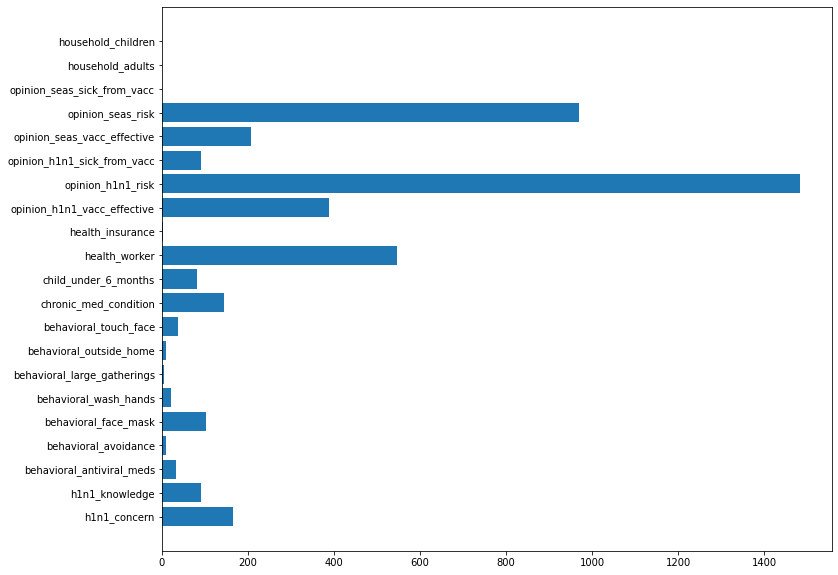

In [91]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

fs = SelectKBest(score_func=chi2, k='all')
fs.fit(df_train_processed, labels_train['h1n1_vaccine'])

columns = list(df_train_for_clf.columns)
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (columns[i], fs.scores_[i]))

# plot the scores
plt.figure(figsize=(12,10))
plt.barh(y=[columns[i] for i in range(len(fs.scores_))], width=fs.scores_)
plt.show()

In [93]:
# Only here to show the graph above is correct with column assigments
fs_top_4 = SelectKBest(score_func=chi2, k=4)

fs_top_4.fit(df_train_processed, labels_train['h1n1_vaccine'])
cols_to_keep = fs_top_4.get_support(indices=True)
features_df_new = df_train_for_clf.iloc[:,cols_to_keep]
features_df_new.columns

Index(['health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_seas_risk'],
      dtype='object')

Feature h1n1_concern: 0.010211
Feature h1n1_knowledge: 0.008445
Feature behavioral_antiviral_meds: 0.000000
Feature behavioral_avoidance: 0.007642
Feature behavioral_face_mask: 0.002358
Feature behavioral_wash_hands: 0.006957
Feature behavioral_large_gatherings: 0.001943
Feature behavioral_outside_home: 0.001529
Feature behavioral_touch_face: 0.002119
Feature chronic_med_condition: 0.003103
Feature child_under_6_months: 0.005932
Feature health_worker: 0.011221
Feature health_insurance: 0.004435
Feature opinion_h1n1_vacc_effective: 0.047777
Feature opinion_h1n1_risk: 0.050310
Feature opinion_h1n1_sick_from_vacc: 0.006087
Feature opinion_seas_vacc_effective: 0.025966
Feature opinion_seas_risk: 0.034982
Feature opinion_seas_sick_from_vacc: 0.000000
Feature household_adults: 0.004599
Feature household_children: 0.000000


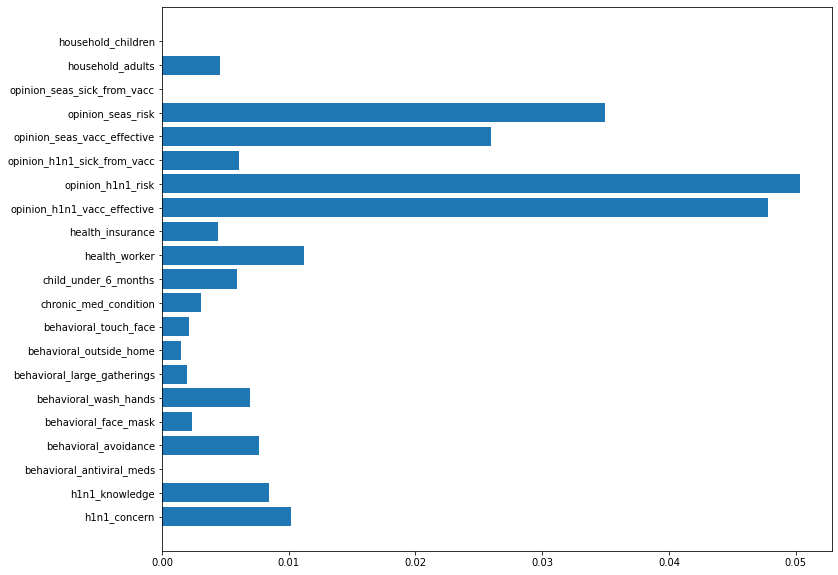

In [94]:
from sklearn.feature_selection import mutual_info_classif

fs = SelectKBest(score_func=mutual_info_classif, k='all')

# df_train_processed = data_preparation_pipeline.fit_transform(df_train_for_clf)
fs.fit(df_train_processed, labels_train['h1n1_vaccine'])

columns = list(df_train_for_clf.columns)
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (columns[i], fs.scores_[i]))

# plot the scores
plt.figure(figsize=(12,10))
plt.barh(y=[columns[i] for i in range(len(fs.scores_))], width=fs.scores_)
plt.show()